*Data Science for Business 1*

# Group Project: Loan approval model

## Import libraries

In [1]:
import pandas as pd
import numpy as np

#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image

#Library for building machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection
import optuna
from optuna.integration import OptunaSearchCV
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt

from scipy.stats import loguniform, expon
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Import data

In [2]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
loans.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

Some columns have extra spaces in front of them so let's fix this.

In [4]:
loans.columns = loans.columns.str.replace(' ', '')

Some values have extra spaces in front of them in the dataframe, let's remove them.

In [5]:
loans['education'] = loans['education'].apply(lambda x: x.replace(' ', ''))
loans['self_employed'] = loans['self_employed'].apply(lambda x: x.replace(' ', ''))
loans['loan_status'] = loans['loan_status'].apply(lambda x: x.replace(' ', ''))

## Data exploration and summary statistics

In [6]:
loans.shape

(4269, 13)

The dataset has 4269 rows and 13 columns.

In [7]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


There are no missing values. The most of the columns are integer Dtype but there are three columns with Dtype object.

In [8]:
loans.describe().round()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0
mean,2135.0,2.0,5059124.0,15133450.0,11.0,600.0,7472617.0,4973155.0,15126306.0,4976692.0
std,1232.0,2.0,2806840.0,9043363.0,6.0,172.0,6503637.0,4388966.0,9103754.0,3250185.0
min,1.0,0.0,200000.0,300000.0,2.0,300.0,-100000.0,0.0,300000.0,0.0
25%,1068.0,1.0,2700000.0,7700000.0,6.0,453.0,2200000.0,1300000.0,7500000.0,2300000.0
50%,2135.0,3.0,5100000.0,14500000.0,10.0,600.0,5600000.0,3700000.0,14600000.0,4600000.0
75%,3202.0,4.0,7500000.0,21500000.0,16.0,748.0,11300000.0,7600000.0,21700000.0,7100000.0
max,4269.0,5.0,9900000.0,39500000.0,20.0,900.0,29100000.0,19400000.0,39200000.0,14700000.0


In [9]:
loans.select_dtypes(include="object")

,education,self_employed,loan_status
0,Graduate,No,Approved
1,NotGraduate,Yes,Rejected
2,Graduate,No,Rejected
3,Graduate,No,Rejected
4,NotGraduate,Yes,Rejected
...,...,...,...
4264,Graduate,Yes,Rejected
4265,NotGraduate,Yes,Approved
4266,NotGraduate,No,Rejected
4267,NotGraduate,No,Approved


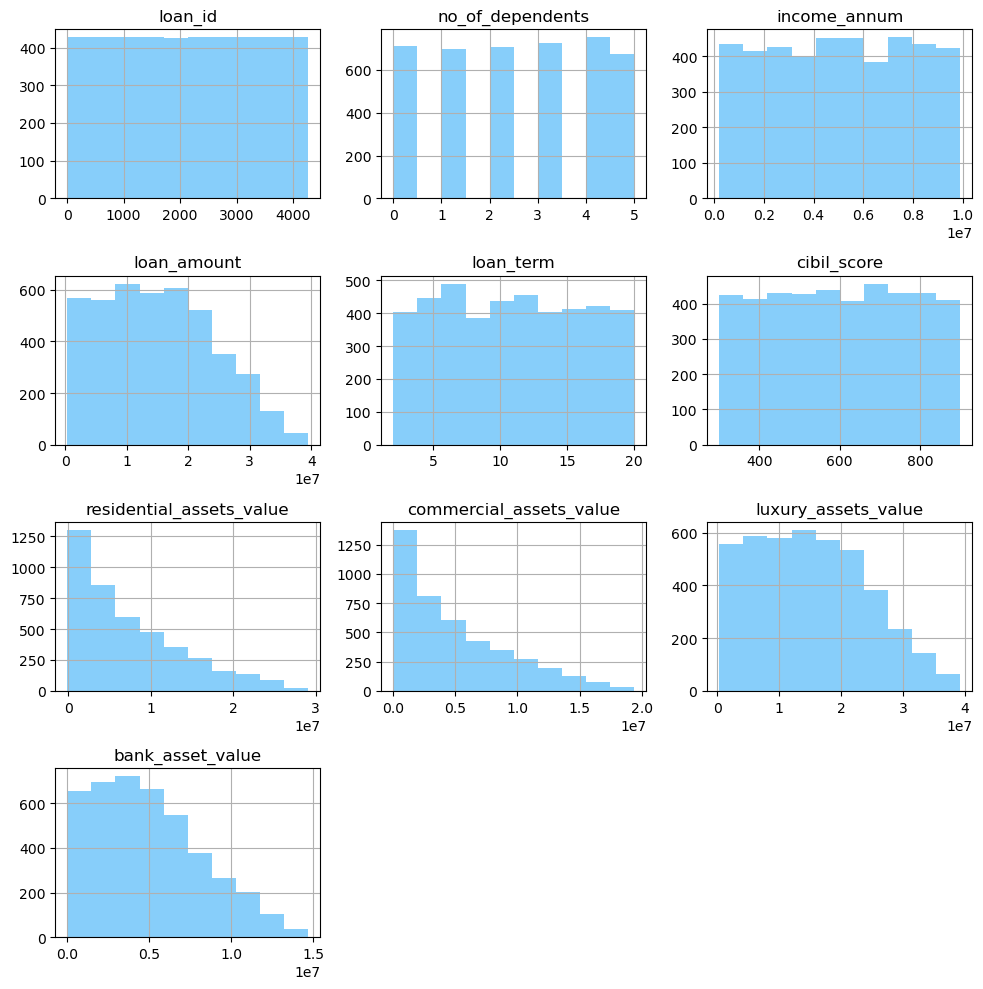

In [10]:
loans.hist(figsize=(10,10), color="lightskyblue")
plt.tight_layout()

## Checking the target class distribution

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


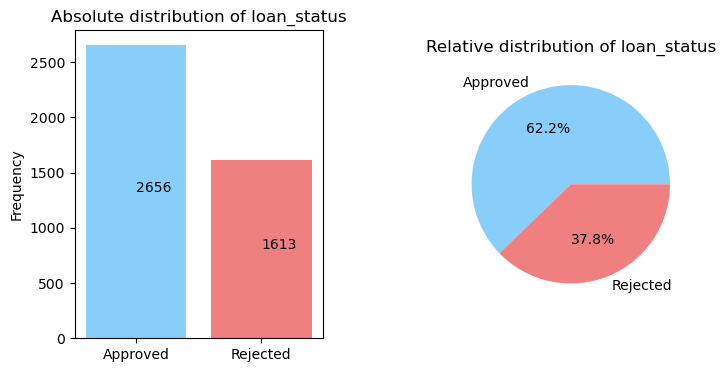

In [11]:
class_counts=loans["loan_status"].value_counts()
print(class_counts)

plt.figure(figsize=(8, 4))
           
plt.subplot(1,2,1)
plt.bar(["Approved", "Rejected"], class_counts, color = ["lightskyblue", "lightcoral"])
plt.title("Absolute distribution of loan_status")
plt.ylabel("Frequency")
plt.text(["Approved"], class_counts[0]/2, class_counts[0])
plt.text(["Rejected"], class_counts[1]/2, class_counts[1])

plt.subplot(1,2,2)
plt.pie(class_counts, labels=["Approved", "Rejected"], autopct="%1.1f%%", colors= ["lightskyblue", "lightcoral"])
plt.title("Relative distribution of loan_status")

plt.subplots_adjust(wspace=0.5)
plt.show()

From the visualization we can see that the loan is "Approved" in 2656 cases so in 62.2% of the cases and "Rejected" in 1613 cases so in 37.8%% of the cases. Most of the credit applications in the dataset are approved.

## Data preprocessing

In [12]:
loans_copy = loans.copy() #Let's copy the loans dataframe just in case

In [13]:
loans.nunique()

loan_id                     4269
no_of_dependents               6
education                      2
self_employed                  2
income_annum                  98
loan_amount                  378
loan_term                     10
cibil_score                  601
residential_assets_value     278
commercial_assets_value      188
luxury_assets_value          379
bank_asset_value             146
loan_status                    2
dtype: int64

Dropping loan_id column as it is just an arbitrary identification number OTETAANKO MYÖS CIBIL SCORE POIS???

In [14]:
loans=loans.drop(["loan_id"], axis=1)
#loans=loans.drop(["cibil_score"], axis=1)
loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,NotGraduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,NotGraduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Let's transform the Dtype object columns into boolean operators

In [15]:
loans.select_dtypes(include="object")

,education,self_employed,loan_status
0,Graduate,No,Approved
1,NotGraduate,Yes,Rejected
2,Graduate,No,Rejected
3,Graduate,No,Rejected
4,NotGraduate,Yes,Rejected
...,...,...,...
4264,Graduate,Yes,Rejected
4265,NotGraduate,Yes,Approved
4266,NotGraduate,No,Rejected
4267,NotGraduate,No,Approved


In [16]:
loans["education"] = loans["education"].replace({"Graduate" : 1, "NotGraduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})
loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


## One-hot encoding no_of_dependents (ei tehty)

In [17]:
#loans = pd.get_dummies(loans, columns=["no_of_dependents",])
#loans.head()

## Separating the data to features X and labels y

In [18]:
X = loans.drop(["loan_status"], axis=1)
y = loans["loan_status"]

## Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3)

## Decision tree model

### Sequential feature selection

In [20]:
dt_sfs = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=3)

Let's do forward selection first

In [21]:
dt_sfs1 = SFS(
    dt_sfs,
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1
)

dt_sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.9s finished
Features: 1/11[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
Features: 2/11[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished
Features: 3/11[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
Features: 4/11[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
Features: 5/11[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
Features: 6/11[Parallel(n_jobs=-1)]: Using backe

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4,
                                                           min_samples_leaf=3,
                                                           random_state=1234),
                          k_features=(1, 11), n_jobs=-1, scoring='accuracy',
                          verbose=1)

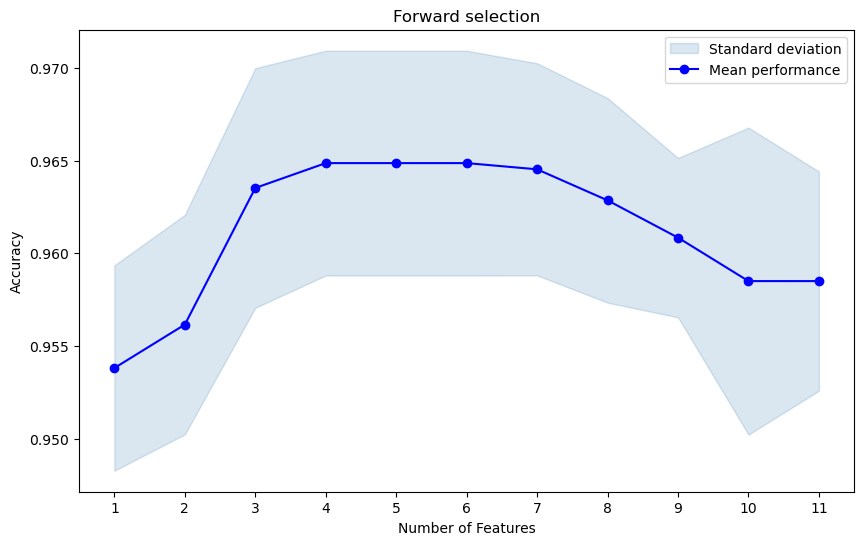

In [22]:
plot_sfs(dt_sfs1.get_metric_dict(), ylabel="Accuracy", figsize=(10,6))
plt.title("Forward selection")
plt.legend(["Standard deviation", "Mean performance"])

In [23]:
dt_sfs1.k_feature_names_

('loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value')

In [24]:
dt_sfs1.k_score_

0.9648633356302134

Now let's try backward selection

In [25]:
dt_sfs2 = SFS(
    dt_sfs,
   k_features=(1, X_train.shape[1]),
    forward=False,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1
)

dt_sfs2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
Features: 10/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
Features: 9/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished
Features: 8/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
Features: 7/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
Features: 6/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
Features: 5/1[Parallel(n_jobs=-1)]: Using backend Lo

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4,
                                                           min_samples_leaf=3,
                                                           random_state=1234),
                          forward=False, k_features=(1, 11), n_jobs=-1,
                          scoring='accuracy', verbose=1)

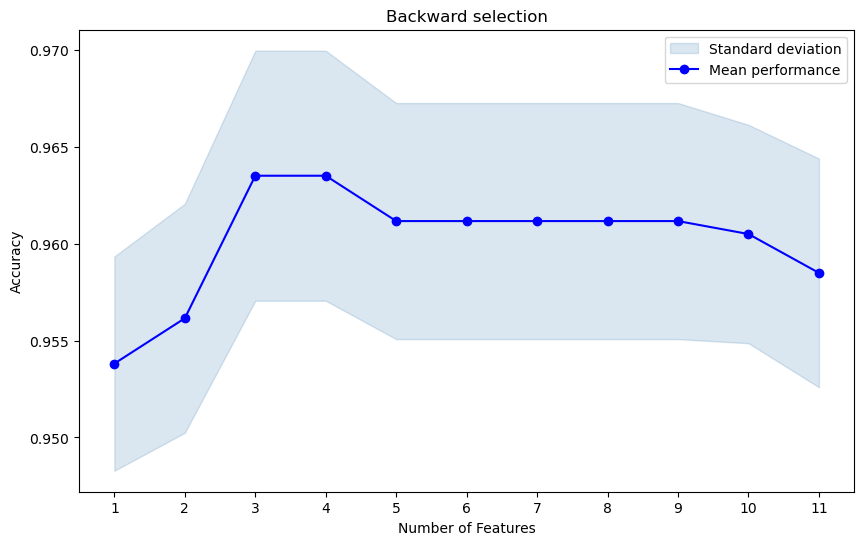

In [26]:
plot_sfs(dt_sfs2.get_metric_dict(), ylabel="Accuracy", figsize=(10,6))
plt.title("Backward selection")
plt.legend(["Standard deviation", "Mean performance"])

In [27]:
dt_sfs2.k_feature_names_

('no_of_dependents', 'loan_amount', 'loan_term', 'cibil_score')

In [28]:
dt_sfs2.k_score_

0.9635227419147018

Let's choose the forward selection as it was slightly better in terms of cross validation score.

Now we make versions of train and test sets that only have the selected features.

In [29]:
X_train_dt_sfs = dt_sfs1.transform(X_train)
X_test_dt_sfs = dt_sfs1.transform(X_test)

Then, we fit the model to the training data.

In [30]:
dt_sfs.fit(X_train_dt_sfs, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=1234)

### Evaluating the final model

In [31]:
y_pred_dt_sfs = dt_sfs.predict(X_test_dt_sfs)
accuracy_score(y_pred_dt_sfs, y_test)

0.9640905542544886

Text(0.5, 1.0, 'Decision tree (normalized)')

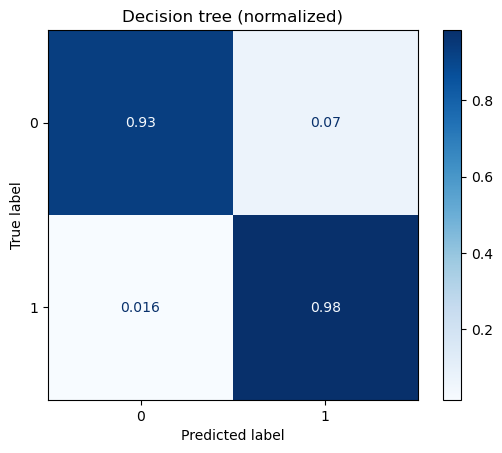

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt_sfs, cmap="Blues", normalize="true")
plt.title("Decision tree (normalized)")

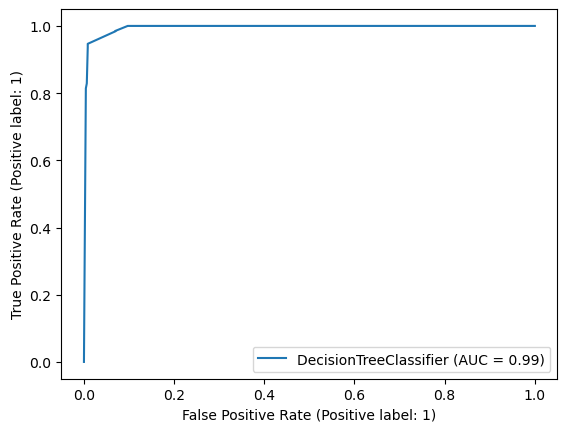

In [33]:
RocCurveDisplay.from_estimator(dt_sfs, X_test_dt_sfs, y_test)

## Other models

In [34]:
#Initial model testing
X = loans.drop("loan_status", axis=1)
y = loans["loan_status"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1234, test_size=0.3)

# Comparing accuracies
accs = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "mlp":0}

In [35]:
knn = KNeighborsClassifier(n_neighbors=7)
accs["knn"] = cross_val_score(knn, X_train, y_train).mean()

In [36]:
lr = LogisticRegression(random_state=1234)
accs["lr"] = cross_val_score(lr, X_train, y_train).mean()

In [37]:
dtc = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=3)
accs["dtc"] = cross_val_score(dtc, X_train, y_train).mean()

In [38]:
rfc = RandomForestClassifier(random_state=1234)
accs["rfc"] = cross_val_score(rfc, X_train, y_train).mean()

In [39]:
svc = SVC(kernel="linear")
accs["svc"] = cross_val_score(svc, X_train, y_train).mean()

In [40]:
mlp = MLPClassifier(activation='identity', solver='sgd', random_state=1234)
accs["mlp"] = cross_val_score(mlp, X_train, y_train).mean()

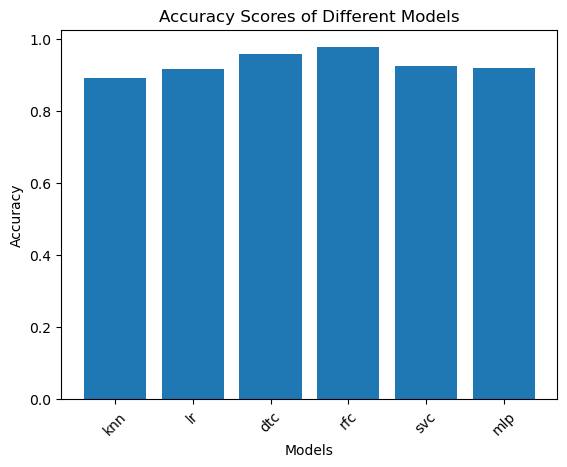

In [41]:
# Assuming you have a list of accuracy scores called accuracy_scores
accuracy_scores = accs.values()

# Create a list of corresponding x-axis values
x_values = range(len(accuracy_scores))

# Plot the bar graph
plt.bar(x_values, accuracy_scores)

# Add labels to the plot
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Models')

# Customize the x-axis tick labels if necessary
plt.xticks(x_values, accs.keys(), rotation=45)

# Display the plot
plt.show()

In [42]:
print(accuracy_scores)

dict_values([0.8905643042413853, 0.9163386609748855, 0.9585037786479779, 0.9772452003607782, 0.9257104922606342, 0.9190148064738407])


## XGBClassifier

In [ ]:
#xgbclass_defaults = XGBClassifier()

In [ ]:
#cross_val_score(xgbclass_defaults, X_train, y_train).mean()

In [ ]:
#params = {
#    "max_depth" : optuna.distributions.IntDistribution(1, 20),
#    "learning_rate" : optuna.distributions.FloatDistribution(1e-5, 1., log=True),
#    "gamma" : optuna.distributions.FloatDistribution(1e-5, 1., log=True)
#}
#
#xgbclass = OptunaSearchCV(
#    XGBClassifier(n_jobs=-1),
#    params,
#    n_trials=30,
#    scoring="accuracy",
#    cv=5,
#    n_jobs=1,
#    refit=True,
#    random_state=1234
#) 

In [ ]:
#xgbclass.fit(X_train, y_train)

In [ ]:
#xgbclass.best_score_
#0.6201475605452009
#0.9825974913586887

In [ ]:
#y_pred_xgbclass = xgbclass.predict(X_test)
#accuracy_score(y_test, y_pred_xgbclass)

In [ ]:
#conf_matrix = confusion_matrix(y_test,y_pred_xgbclass)

In [ ]:
#conf_matrix_normalized = conf_matrix/len(y_test)
#conf_matrix_normalized = conf_matrix_normalized.round(4)

In [ ]:
#fig, ax = plt.subplots(figsize=(7.5, 7.5))
#ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
#for i in range(conf_matrix.shape[0]):
#    for j in range(conf_matrix.shape[1]):
#        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
# 
#plt.xlabel('Predictions', fontsize=18)
#plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
#plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(7.5, 7.5))
#ax.matshow(conf_matrix_normalized, cmap=plt.cm.Blues, alpha=0.3)
#for i in range(conf_matrix_normalized.shape[0]):
#    for j in range(conf_matrix_normalized.shape[1]):
#        ax.text(x=j, y=i,s=conf_matrix_normalized[i, j], va='center', ha='center', size='xx-large')
# 
#plt.xlabel('Predictions', fontsize=18)
#plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
#plt.show()